In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import upsetplot

import statsmodels.api as sm
import statsmodels.formula.api as smf

from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr

import plotting
from plotting import PAPER_PRESET, PAPER_FONTSIZE, nice_boxplot, mimic_r_boxplot


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
from data_loading import (load_annotated_6k_collection,
                          load_valid_isoform_clones,
                          load_developmental_tissue_expression_gencode)

In [4]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

In [5]:
# base code
import numpy as np
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

In [6]:
pal = {"ref": sns.color_palette("Set2")[0],
       "rewire": sns.color_palette("Set2")[2],
       "DN": sns.color_palette("Set2")[1],
       "NA": "lightgray",
       "likely": "darkgray"}

## variables

In [7]:
dn_f = "../data/processed/TF-iso_ref-vs-alt.DN_cat.tsv"

In [8]:
joung_orf_f = "../data/external/joung_files/Joung_ORF_lib.txt"
joung_data_f = "../data/external/joung_files/Joung_ORF_scores.txt"
joung_cells_f = "../data/external/joung_files/Figure3B_celltype_mapping.csv"

In [9]:
joung_down_map_batch_f = "../data/external/joung_files/subsample_mapping_batch.txt"
joung_down_map_TF_f = "../data/external/joung_files/subsample_mapping_TF.txt"
joung_down_map_louvain_f = "../data/external/joung_files/subsample_mapping_louvain.txt"

## 1. import data

In [10]:
dn = pd.read_table(dn_f)

In [11]:
joung_orf = pd.read_table(joung_orf_f)
joung_orf["Name"] = joung_orf["Name"].str.strip()

In [12]:
joung_data = pd.read_table(joung_data_f)
joung_data["Name"] = joung_data["TF ORF"].str.split("-", expand=True)[0].str.strip()

In [13]:
joung_cells = pd.read_table(joung_cells_f, sep=",")

In [14]:
joung_down_map_batch = pd.read_table(joung_down_map_batch_f, index_col=0)
print(len(joung_down_map_batch))
joung_down_map_TF = pd.read_table(joung_down_map_TF_f, index_col=0)
print(len(joung_down_map_TF))
joung_down_map_louvain = pd.read_table(joung_down_map_louvain_f, index_col=0)
print(len(joung_down_map_louvain))

joung_down_map = joung_down_map_batch.join(joung_down_map_TF).join(joung_down_map_louvain)
print(len(joung_down_map))

671453
671453
671453
671453


## 2. map our clones to their ORFs

In [15]:
tfs = load_annotated_6k_collection()

reading from cache


In [16]:
def pd_translate(row):
    s = Seq(row["ORF sequence"])
    aa = s.translate()
    return str(aa)

joung_orf["seq_aa"] = joung_orf.apply(pd_translate, axis=1)

In [17]:
tf_id_map = {}
for tf in tfs:
    isos = tfs[tf]
    for i, iso in enumerate(isos.isoforms):
        sub_dict = {}
        try: 
            iso_clone_acc = iso.clone_acc
        except AttributeError:
            continue

        try:
            iso_seq_aa = iso.aa_seq_GENCODE
        except AttributeError:
            iso_seq_aa = iso.aa_seq
        iso_ensts = iso.ensembl_transcript_ids

        
        # first try to match based on aa seq
        joung_sub = joung_orf[joung_orf["seq_aa"] == iso_seq_aa]
        
        if len(joung_sub) > 0:
            sub_dict["match_type"] = "seq_aa"
            sub_dict["joung_id"] = joung_sub["Name"].iloc[0]
        
        # if not found, then try ensts
        if len(joung_sub) == 0:
            if iso_ensts is None:
                continue
            
            for iso_enst in iso_ensts:
                joung_sub = joung_orf[joung_orf["RefSeq and Gencode ID"].str.contains(iso_enst)]
                if len(joung_sub) > 0:
                    continue
            
            if len(joung_sub) > 0:
                sub_dict["match_type"] = "enst"
                sub_dict["joung_id"] = joung_sub["Name"].iloc[0]
            else:
                continue
        
        sub_dict["enst"] = iso_ensts
        sub_dict["seq_aa"] = iso_seq_aa
        tf_id_map[iso_clone_acc] = sub_dict

In [18]:
tf_id_map_df = pd.DataFrame.from_dict(tf_id_map, orient="index").reset_index()
print(len(tf_id_map_df))
tf_id_map_df.sample(5)

452


,index,match_type,joung_id,enst,seq_aa
252,MYF6|2/2|03F09,seq_aa,TFORF3025,[ENST00000228641],MMMDLFETGSYFFYLDGENVTLQPLEVAEGSPLYPGSDGTLSPCQD...
19,LHX8|1/2|12A10,seq_aa,TFORF0825,[ENST00000294638],MQILSRCQGLMSEECGRTTALAAGRTRKGAGEEGLVSPEGAGDEDS...
247,ZBTB44|3/9|10B06,seq_aa,TFORF3053,[ENST00000525842],MGVKTFTHSSSSHSQEMLGKLNMLRNDGHFCDITIRVQDKIFRAHK...
126,HSF2|1/2|12B08,seq_aa,TFORF2573,[ENST00000368455],MKQSSNVPAFLSKLWTLVEETHTNEFITWSQNGQSFLVLDEQRFAK...
76,ZKSCAN7|1/2|06A08,seq_aa,TFORF2767,"[ENST00000341840, ENST00000431636]",MTTAGRGNLGLIPRSTAFQKQEGRLTVKQEPANQTWGQGSSLQKNY...


In [19]:
joung_orf = joung_orf.merge(tf_id_map_df, left_on="Name", right_on="joung_id", how="left", suffixes=("_joung",
                                                                                                     "_tf1p0"))
joung_orf.sample(5)

,Source,Name,RefSeq Gene Name,RefSeq and Gencode ID,Isoform ID,Insert,ORF sequence,Barcode Sequence,Epitope Tag,Unsorted M1,...,Sorted M4,Sorted M5,Sorted M6,Sorted M7,seq_aa_joung,index,match_type,joung_id,enst,seq_aa_tf1p0
1068,Genewiz,TFORF1069,NFATC2,"NM_012340,ENST00000371564",NFATC2-5,ACCGCCACCATGAACGCCCCCGAGCGGCAGCCCCAACCCGACGGCG...,ATGAACGCCCCCGAGCGGCAGCCCCAACCCGACGGCGGGGACGCCC...,CCTGTCGTATAACCTATGTGAGAC,None,0.255685,...,0.793011,0.215364,6.633765,0.895875,MNAPERQPQPDGGDAPGHEPGGSPQDELDFSILFDYEYLNPNEEEP...,NaN,NaN,NaN,NaN,NaN
948,Genewiz,TFORF0949,EMX1,"NM_004097,ENST00000258106",EMX1-1,ACCGCCACCATGTGCCTGGCTGGGTGCACACCCCGCAAGGCGGCGG...,ATGTGCCTGGCTGGGTGCACACCCCGCAAGGCGGCGGCGCCAGGAC...,GGCAATTGCGGCGCTATCACCTAA,None,2.545823,...,0.956843,1.103402,0.944190,1.156905,MCLAGCTPRKAAAPGRGALPRARLPRTAPAAATMFQPAAKRGFTIE...,NaN,NaN,NaN,NaN,NaN
2212,Genewiz,TFORF2213,CREB3L1,"NM_052854,ENST00000621158",CREB3L1-1,ACCGCCACCATGGACGCCGTCTTGGAACCCTTCCCGGCCGACAGGC...,ATGGACGCCGTCTTGGAACCCTTCCCGGCCGACAGGCTGTTCCCCG...,TGTTTGTGCGACCAGCAGAACCGT,None,0.713095,...,1.186998,0.831158,0.851459,1.057196,MDAVLEPFPADRLFPGSSFLDLGDLNESDFLNNAHFPEHLDHFTEN...,NaN,NaN,NaN,NaN,NaN
22,Genewiz,TFORF0023,IRX2,"XM_011513979,NM_033267,NM_001134222,ENST000003...",IRX2-1,ACCGCCACCATGTCCTACCCGCAGGGCTACCTGTACCAGGCGCCCG...,ATGTCCTACCCGCAGGGCTACCTGTACCAGGCGCCCGGCTCGCTGG...,CTATTGAAGCAGGCAATAGCTCTT,None,0.496131,...,1.867945,1.357473,1.923434,2.991399,MSYPQGYLYQAPGSLALYSCPAYGASALAAPRSEELARSASGSAFS...,NaN,NaN,NaN,NaN,NaN
3267,Broad GPP,TFORF3267,SNAPC2,NM_003083.3,SNAPC2-1,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGAAGCCAC...,ATGAAGCCACCTCCCAGGCGGCGAGCGGCCCCGGCGCGCTATCTGG...,AAACTGTACGAACGTCTATCCGGT,V5,0.785812,...,0.622552,0.792657,0.966422,0.770994,MKPPPRRRAAPARYLGEVTGPATWSAREKRQLVRLLQARQGQPEPD...,NaN,NaN,NaN,NaN,NaN


## 3. intersect our DN categorizations with their scores

In [20]:
joung_data = joung_orf.merge(joung_data, on="Name", how="left")

In [21]:
dn_ref = dn[["gene_symbol", "family", "clone_acc_ref", "is_ref_novel_isoform", "is_MANE_select_isoform_cloned",
             "dn_short"]].drop_duplicates()
dn_ref.columns = ["gene_name", "family", "tf1p0_id", "is_novel", "is_MANE_select", "dn_cat"]
dn_ref["dn_cat"] = "ref"
dn_ref["iso_status"] = "ref"

In [22]:
dn_alt = dn[["gene_symbol", "family", "clone_acc_alt", "is_alt_novel_isoform", "is_MANE_select_isoform_cloned",
             "dn_short"]].drop_duplicates()
dn_alt.columns = ["gene_name", "family", "tf1p0_id", "is_novel", "is_MANE_select", "dn_cat"]
dn_alt["is_MANE_select"] = False # assuming none of the alts are the MANE select
dn_alt["iso_status"] = "alt"

In [23]:
dn_cats = dn_ref.append(dn_alt).drop_duplicates()

In [24]:
dn_cats = dn_cats.merge(joung_data, left_on="tf1p0_id", right_on="index", how="left")
dn_cats.sample(5)

,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,index,match_type,joung_id,enst,seq_aa_tf1p0,TF ORF,Diffusion P-value,Diffusion difference,RNA Velocity P-value,RNA Velocity difference
668,ZNF433,C2H2 ZF,ZNF433|2/2|06G02,False,False,NaN,alt,Broad GPP,TFORF3161,ZNF433,...,ZNF433|2/2|06G02,seq_aa,TFORF3161,[ENST00000419886],MQETFRNLASIGKKWKPQNIYVEYENLRRNLRIVGERLFESKEGHQ...,TFORF3161-ZNF433,0.073983,-0.000352,0.067233,-0.014942
606,TCF4,bHLH,TCF4|8/9|07A05,False,False,rewire,alt,Genewiz,TFORF0259,TCF4,...,TCF4|8/9|07A05,seq_aa,TFORF0259,[ENST00000561831],MKFKQCRCSDTGLCCLDHEGKAEVYAPSASTADYNRDSPGYPSSKP...,TFORF0259-TCF4,0.000821,0.000673,0.174313,-0.004663
531,ESR2,Nuclear receptor,ESR2|3/3|07H11,False,False,NaN,alt,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,ZNF410,C2H2 ZF,ZNF410|1/5|05G08,False,True,ref,ref,Genewiz,TFORF2188,ZNF410,...,ZNF410|1/5|05G08,seq_aa,TFORF2188,[ENST00000555044],MLSDELESKPELLVQFVQNTSIPLGQGLVESEAKDITCLSLLPVTE...,TFORF2188-ZNF410,0.198251,0.003982,0.218295,0.005122
378,TFAP2A,AP-2,TFAP2A|3/4|09D06,False,False,rewire,alt,Genewiz,TFORF1328,TFAP2A,...,TFAP2A|3/4|09D06,seq_aa,TFORF1328,[ENST00000319516],MSILAKMGDWQDRHDGTSNGTARLPQLGTVGQSPYTSAPPLSHTPN...,TFORF1328-TFAP2A,0.082996,-0.012894,0.000145,-0.028398


## 4. count overlap between collections

In [25]:
dn_cats.iso_status.value_counts()

alt    447
ref    246
Name: iso_status, dtype: int64

In [26]:
dn_cats[~pd.isnull(dn_cats["Name"])].iso_status.value_counts()

ref    220
alt    182
Name: iso_status, dtype: int64

In [27]:
refs_inc = len(dn_cats[(~pd.isnull(dn_cats["Name"])) & (dn_cats["iso_status"] == "ref")])
refs_tf1p0 = len(dn_cats[dn_cats["iso_status"] == "ref"])
print("%% of our ref seqs included in joung: %s" % (refs_inc/refs_tf1p0*100))

% of our ref seqs included in joung: 89.43089430894308


In [28]:
alts_inc = len(dn_cats[(~pd.isnull(dn_cats["Name"])) & (dn_cats["iso_status"] == "alt")])
alts_tf1p0 = len(dn_cats[dn_cats["iso_status"] == "alt"])
print("%% of our alt seqs included in joung: %s" % (alts_inc/alts_tf1p0*100))

% of our alt seqs included in joung: 40.7158836689038


In [29]:
missing_ref = dn_cats[(dn_cats["iso_status"] == "ref") & (pd.isnull(dn_cats["Name"]))]
missing_ref.is_novel.value_counts()

False    15
True     11
Name: is_novel, dtype: int64

In [30]:
missing_ref[~missing_ref["is_novel"]].is_MANE_select.value_counts(dropna=False)

False    12
True      2
NaN       1
Name: is_MANE_select, dtype: int64

In [31]:
missing_ref[(~missing_ref["is_novel"]) & (missing_ref["is_MANE_select"] == True)]

,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,index,match_type,joung_id,enst,seq_aa_tf1p0,TF ORF,Diffusion P-value,Diffusion difference,RNA Velocity P-value,RNA Velocity difference
182,ZNF207,C2H2 ZF,ZNF207|1/4|01E12,False,True,ref,ref,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,ZGPAT,CCCH ZF,ZGPAT|1/2|01A06,False,True,ref,ref,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# a lot more transcripts are missing here since the seq_aa includes muts
# asked luke to see if he can add the ref seq_aa as an attribute to merge on

In [33]:
missing_alt = dn_cats[(dn_cats["iso_status"] == "alt") & (pd.isnull(dn_cats["Name"]))]
missing_alt.is_novel.value_counts()

True     169
False     96
Name: is_novel, dtype: int64

In [34]:
dn_cats["orf_len"] = dn_cats["seq_aa_joung"].str.len()

## 5. join DN categories with cell counts

In [35]:
joung_down_tf1p0_map = joung_down_map.merge(dn_cats[["TF ORF", "tf1p0_id", "iso_status", "dn_cat", "orf_len"]],
                                           left_on="TF", right_on="TF ORF")
print(len(joung_down_tf1p0_map))
print(len(joung_down_tf1p0_map["TF ORF"].unique()))

76492
399


In [36]:
joung_down_tf1p0_map.fillna("NA", inplace=True)

In [37]:
joung_tf1p0_cnts = joung_down_tf1p0_map.groupby(["TF", "tf1p0_id", "iso_status", 
                                                 "dn_cat", "orf_len"])["TF ORF"].agg("count").reset_index()
joung_tf1p0_cnts.columns = ["TF", "tf1p0_id", "iso_status", "dn_cat", "orf_len", "tot_cell_cnt"]
joung_tf1p0_cnts.head()

,TF,tf1p0_id,iso_status,dn_cat,orf_len,tot_cell_cnt
0,TFORF0034-SP2,SP2|1/5|02B02,ref,ref,613.0,13
1,TFORF0049-MAX,MAX|2/6|07F12,alt,NA,151.0,996
2,TFORF0066-ZNF451,ZNF451|2/8|06C02,ref,ref,559.0,29
3,TFORF0115-SMAD3,SMAD3|3/4|06B08,alt,DN,381.0,862
4,TFORF0126-CXXC1,CXXC1|2/5|09F10,ref,ref,656.0,68


## 6. create dataframe for linear model

In [38]:
lm = dn_cats[["gene_name", "family", "tf1p0_id", "is_novel", "dn_cat", "iso_status",
              "Diffusion P-value", "Diffusion difference", "orf_len"]]
lm.columns = ["gene_name", "family", "tf1p0_id", "is_novel", "dn_cat", "iso_status", 
              "diff_pval", "diff_diff", "orf_len"]
lm["dn_cat"].replace("ref", "*ref", inplace=True)
lm["iso_status"].replace("ref", "*ref", inplace=True)
lm["dn_cat"].fillna("NA", inplace=True)
lm = lm.merge(joung_tf1p0_cnts[["tf1p0_id", "tot_cell_cnt"]], on=["tf1p0_id"])
lm = lm[lm["dn_cat"] != "likely"]
print(len(lm))
lm.sample(5)

399


,gene_name,family,tf1p0_id,is_novel,dn_cat,iso_status,diff_pval,diff_diff,orf_len,tot_cell_cnt
2,POU2F1,Homeodomain; POU,POU2F1|2/2|04D01,False,*ref,*ref,0.456208,0.001600,743.0,14
19,CREB1,bZIP,CREB1|2/2|01F12,False,*ref,*ref,0.351410,-0.004511,327.0,62
74,IRF5,IRF,IRF5|1/5|07C09,False,*ref,*ref,0.143954,0.003097,514.0,156
295,HMBOX1,Homeodomain,HMBOX1|3/5|03E06,False,rewire,alt,0.000014,0.003310,405.0,418
374,ZNF544,C2H2 ZF,ZNF544|7/7|02H04,False,NA,alt,0.000569,0.001537,75.0,1000


In [39]:
lm.dn_cat.value_counts()

*ref      218
NA        104
rewire     42
DN         35
Name: dn_cat, dtype: int64

In [40]:
# log transform counts and p-values
lm["neglog_diff_pval"] = -np.log10(lm["diff_pval"])
lm["log_count"] = np.log10(lm["tot_cell_cnt"])

## 7. run regression to control for cell count variable

In [41]:
mod = smf.ols(formula='neglog_diff_pval ~ log_count + dn_cat', data=lm)

In [42]:
res = mod.fit()

In [43]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       neglog_diff_pval   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     50.26
Date:                Thu, 25 May 2023   Prob (F-statistic):           3.61e-34
Time:                        10:41:50   Log-Likelihood:                -543.80
No. Observations:                 399   AIC:                             1098.
Df Residuals:                     394   BIC:                             1118.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.6031      0.156  

In [44]:
cls = Linear_Reg_Diagnostic(res)

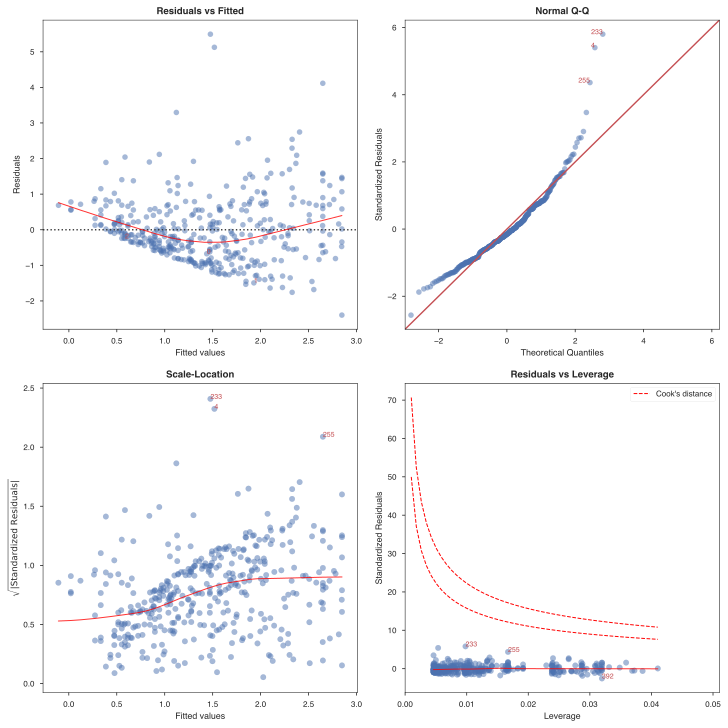

           Features  VIF Factor
3  dn_cat[T.rewire]        1.09
4         log_count        1.12
2      dn_cat[T.NA]        1.15
1      dn_cat[T.DN]        1.15
0         Intercept       10.76


In [45]:
fig, ax = cls()
fig.savefig("../figures/Joung_Model_QC.pdf", dpi="figure", bbox_inches="tight")

## 8. plot ORFeome p-values across categories

In [46]:
dn_cats_nonan = dn_cats[~pd.isnull(dn_cats["Diffusion P-value"])]
len(dn_cats_nonan)

400

In [47]:
dn_cats_nonan["neglog_diff_pval"] = -np.log10(dn_cats_nonan["Diffusion P-value"])
dn_cats_nonan.fillna("NA", inplace=True)

0.01840340802203222
1.451318220091276e-05
0.004197204180628575
0.09043640261294955
218
42
35
104


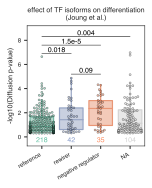

In [48]:
nice_boxplot(dn_cats_nonan, "neglog_diff_pval", "dn_cat", pal, 
             ["ref", "rewire", "DN", "NA"], [6.9, 7.6, 8.3, 5.2], -0.02, 
             "", ["reference", "rewirer", "negative regulator", "NA"], 
             "-log10(Diffusion p-value)", False, (-0.75, 9.2), 
             "effect of TF isoforms on differentiation\n(Joung et al.)", "../figures/Joung_DiffP_Boxplot.pdf")

0.2721920237333971
0.3526824555894498
0.44055211185868803
0.04891682603894105
218
42
35
104


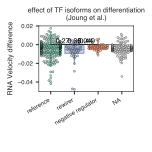

In [49]:
nice_boxplot(dn_cats_nonan, "RNA Velocity difference", "dn_cat", pal, 
             ["ref", "rewire", "DN", "NA"], [0, 0, 0, 0], -0.1, 
             "", ["reference", "rewirer", "negative regulator", "NA"], 
             "RNA Velocity difference", False, (-0.05, 0.02), 
             "effect of TF isoforms on differentiation\n(Joung et al.)", "../figures/Joung_DiffDiff_Boxplot.pdf")

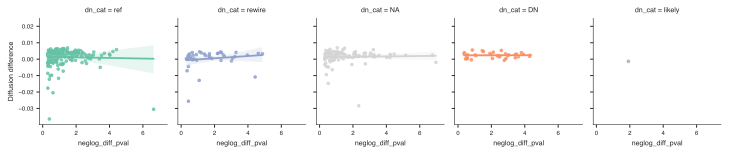

In [50]:
sns.lmplot(data=dn_cats_nonan, x="neglog_diff_pval", y="Diffusion difference", 
           hue="dn_cat", palette=pal, col="dn_cat", height=2, scatter_kws={"s": 7})

## 9. plot p-values across cell count quartiles

In [51]:
joung_tf1p0_cnts["cell_cnt_qcut"] = pd.qcut(joung_tf1p0_cnts["tot_cell_cnt"], q=4, labels=[1, 2, 3, 4])

In [52]:
dn_cats_nonan = dn_cats_nonan.merge(joung_tf1p0_cnts[["TF", "tot_cell_cnt", "cell_cnt_qcut"]], 
                                    left_on="TF ORF", right_on="TF")

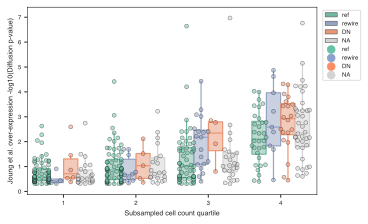

In [53]:
fig = plt.figure(figsize=(5, 3))

ax = sns.boxplot(data=dn_cats_nonan, x="cell_cnt_qcut", y="neglog_diff_pval", hue="dn_cat", palette=pal, 
                 hue_order=["ref", "rewire", "DN", "NA"], fliersize=0)

sns.swarmplot(data=dn_cats_nonan, x="cell_cnt_qcut", y="neglog_diff_pval", hue="dn_cat", palette=pal,
              hue_order=["ref", "rewire", "DN", "NA"], ax=ax, split=True,
              size=4, edgecolor="black", linewidth=0.5, alpha=0.5)

mimic_r_boxplot(ax)

ax.set_xlabel("Subsampled cell count quartile")
ax.set_ylabel("Joung et al. over-expression -log10(Diffusion p-value)")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), facecolor="white")

fig.savefig("../figures/Joung_DiffP_Boxplot_QCut.pdf", dpi="figure", bbox_inches="tight")

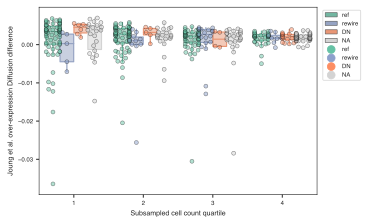

In [54]:
fig = plt.figure(figsize=(5, 3))

ax = sns.boxplot(data=dn_cats_nonan, x="cell_cnt_qcut", y="Diffusion difference", hue="dn_cat", palette=pal, 
                 hue_order=["ref", "rewire", "DN", "NA"], fliersize=0)

sns.swarmplot(data=dn_cats_nonan, x="cell_cnt_qcut", y="Diffusion difference", hue="dn_cat", palette=pal,
              hue_order=["ref", "rewire", "DN", "NA"], ax=ax, split=True,
              size=4, edgecolor="black", linewidth=0.5, alpha=0.5)

mimic_r_boxplot(ax)

ax.set_xlabel("Subsampled cell count quartile")
ax.set_ylabel("Joung et al. over-expression Diffusion difference")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), facecolor="white")

fig.savefig("../figures/Joung_DiffDiff_Boxplot_QCut.pdf", dpi="figure", bbox_inches="tight")

## 10. scatter for ref v alt

In [55]:
dn_cats_nonan_ref = dn_cats_nonan[dn_cats_nonan["iso_status"] == "ref"]
dn_cats_nonan_alt = dn_cats_nonan[dn_cats_nonan["iso_status"] == "alt"]
dn_cats_nonan_diff = dn_cats_nonan_ref.merge(dn_cats_nonan_alt, on=["gene_name", "family", "RefSeq Gene Name"],
                                             how="left", suffixes=("_ref", "_alt"))
dn_cats_nonan_diff["diff_pval_diff"] = dn_cats_nonan_diff["Diffusion P-value_ref"] - dn_cats_nonan_diff["Diffusion P-value_alt"]
dn_cats_nonan_diff["diff_diff_diff"] = dn_cats_nonan_diff["Diffusion difference_ref"] - dn_cats_nonan_diff["Diffusion difference_alt"]

dn_cats_nonan_diff["abs_ddd"] = np.abs(dn_cats_nonan_diff["diff_diff_diff"])

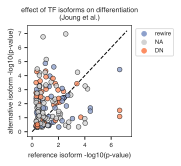

In [56]:
fig = plt.figure(figsize=(2.4, 2.2))

ax = sns.scatterplot(data=dn_cats_nonan_diff[dn_cats_nonan_diff["dn_cat_alt"] != "likely"], 
                     x="neglog_diff_pval_ref", y="neglog_diff_pval_alt",
                     hue="dn_cat_alt", palette=pal, linewidth=0.5, edgecolor="black", alpha=0.8, zorder=10)
ax.set_xlabel("reference isoform -log10(p-value)")
ax.set_ylabel("alternative isoform -log10(p-value)")
ax.set_title("effect of TF isoforms on differentiation\n(Joung et al.)")
# ax.set_xlim((0, 7.2))
# ax.set_ylim((0, 7.2))
ax.plot([0, 7.2], [0, 7.2], linestyle="dashed", color="black", linewidth=1, zorder=1)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

fig.savefig("../figures/Joung_Scatter.inc_NA.pdf", dpi="figure", bbox_inches="tight")

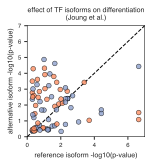

In [57]:
fig = plt.figure(figsize=(2, 2.2))

ax = sns.scatterplot(data=dn_cats_nonan_diff[dn_cats_nonan_diff["dn_cat_alt"].isin(["rewire", "DN"])], 
                     x="neglog_diff_pval_ref", y="neglog_diff_pval_alt",
                     hue="dn_cat_alt", palette=pal, linewidth=0.5, edgecolor="black", alpha=0.8, zorder=10)
ax.set_xlabel("reference isoform -log10(p-value)")
ax.set_ylabel("alternative isoform -log10(p-value)")
ax.set_title("effect of TF isoforms on differentiation\n(Joung et al.)")

ax.set_xlim((0, 7))
ax.set_ylim((0, 7))
ax.plot([0, 7], [0, 7], linestyle="dashed", color="black", linewidth=1, zorder=1)

ax.get_legend().remove()

fig.savefig("../figures/Joung_Scatter.pdf", dpi="figure", bbox_inches="tight")

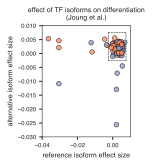

In [58]:
fig = plt.figure(figsize=(2, 2.2))

ax = sns.scatterplot(data=dn_cats_nonan_diff[dn_cats_nonan_diff["dn_cat_alt"].isin(["rewire", "DN"])], 
                     x="Diffusion difference_ref", y="Diffusion difference_alt",
                     hue="dn_cat_alt", palette=pal, linewidth=0.5, edgecolor="black", alpha=0.8, zorder=10)
ax.set_xlabel("reference isoform effect size")
ax.set_ylabel("alternative isoform effect size")
ax.set_title("effect of TF isoforms on differentiation\n(Joung et al.)")

ax.set_xlim((-0.04, 0.01))
ax.set_ylim((-0.03, 0.01))
ax.plot([-0.0025, -0.0025], [-0.0025, 0.0075], linestyle="dashed", color="black", linewidth=0.5)
ax.plot([-0.0025, 0.0075], [-0.0025, -0.0025], linestyle="dashed", color="black", linewidth=0.5)
ax.plot([-0.0025, 0.0075], [0.0075, 0.0075], linestyle="dashed", color="black", linewidth=0.5)
ax.plot([0.0075, 0.0075], [-0.0025, 0.0075], linestyle="dashed", color="black", linewidth=0.5)
# ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)

ax.get_legend().remove()

fig.savefig("../figures/Joung_Scatter_EffSize.pdf", dpi="figure", bbox_inches="tight")

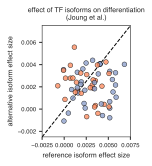

In [59]:
fig = plt.figure(figsize=(2, 2.2))

ax = sns.scatterplot(data=dn_cats_nonan_diff[dn_cats_nonan_diff["dn_cat_alt"].isin(["rewire", "DN"])], 
                     x="Diffusion difference_ref", y="Diffusion difference_alt",
                     hue="dn_cat_alt", palette=pal, linewidth=0.5, edgecolor="black", alpha=0.8, zorder=10)
ax.set_xlabel("reference isoform effect size")
ax.set_ylabel("alternative isoform effect size")
ax.set_title("effect of TF isoforms on differentiation\n(Joung et al.)")

ax.set_xlim((-0.0025, 0.0075))
ax.set_ylim((-0.0025, 0.0075))
ax.plot([-0.0025, 0.0075], [-0.0025, 0.0075], linestyle="dashed", color="black", linewidth=1, zorder=1)

ax.get_legend().remove()

fig.savefig("../figures/Joung_Scatter_EffSize_Zoom.pdf", dpi="figure", bbox_inches="tight")

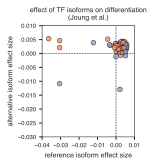

In [60]:
fig = plt.figure(figsize=(2, 2.2))

ax = sns.scatterplot(data=dn_cats_nonan_diff[(dn_cats_nonan_diff["dn_cat_alt"].isin(["rewire", "DN"])) &
                                             (dn_cats_nonan_diff["Diffusion P-value_alt"] < 0.1)], 
                     x="Diffusion difference_ref", y="Diffusion difference_alt",
                     hue="dn_cat_alt", palette=pal, linewidth=0.5, edgecolor="black", alpha=0.8, zorder=10)
ax.set_xlabel("reference isoform effect size")
ax.set_ylabel("alternative isoform effect size")
ax.set_title("effect of TF isoforms on differentiation\n(Joung et al.)")

ax.set_xlim((-0.04, 0.01))
ax.set_ylim((-0.03, 0.01))
ax.axhline(y=0, linestyle="dashed", color="black", linewidth=0.5)
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)

ax.get_legend().remove()

#fig.savefig("../figures/Joung_Scatter.pdf", dpi="figure", bbox_inches="tight")

In [61]:
tmp = dn_cats_nonan_diff[dn_cats_nonan_diff["dn_cat_alt"].isin(["rewire", "DN"])]
tmp.sort_values(by="Diffusion difference_alt", ascending=True)[["tf1p0_id_ref", "tf1p0_id_alt", "dn_cat_alt",
                                                             "Name_ref", "Name_alt", "Diffusion difference_ref",
                                                                  "Diffusion difference_alt",
                                                             "neglog_diff_pval_ref", "neglog_diff_pval_alt",
                                                             "tot_cell_cnt_ref", "tot_cell_cnt_alt"]].head(20)

,tf1p0_id_ref,tf1p0_id_alt,dn_cat_alt,Name_ref,Name_alt,Diffusion difference_ref,Diffusion difference_alt,neglog_diff_pval_ref,neglog_diff_pval_alt,tot_cell_cnt_ref,tot_cell_cnt_alt
78,TFAP2A|2/4|09G07,TFAP2A|4/4|11C09,rewire,TFORF1329,TFORF2932,0.002105,-0.025605,1.269048,0.437759,224,40.0
77,TFAP2A|2/4|09G07,TFAP2A|3/4|09D06,rewire,TFORF1329,TFORF1328,0.002105,-0.012894,1.269048,1.080941,224,112.0
6,GRHL3|3/7|08G09,GRHL3|4/7|08F09,rewire,TFORF2165,TFORF2168,-0.030514,-0.010852,6.643974,4.430626,111,152.0
27,ATF2|1/6|12H04,ATF2|2/6|09E05,rewire,TFORF3485,TFORF0802,0.002551,-0.007084,0.304267,0.355896,105,20.0
230,NFIX|1/4|08H03,NFIX|2/4|08G06,rewire,TFORF2928,TFORF2930,0.005462,-0.004477,1.223751,0.432936,9,23.0
199,TGIF1|3/3|02B10,TGIF1|1/3|02H07,rewire,TFORF2996,TFORF2568,-0.000029,-0.001075,0.343216,3.015921,78,135.0
204,TCF4|1/9|07E01,TCF4|3/9|07C04,rewire,TFORF3520,TFORF3519,0.005162,-0.000781,2.277874,2.388860,9,252.0
28,ATF2|1/6|12H04,ATF2|3/6|09C05,DN,TFORF3485,TFORF0803,0.002551,-0.000681,0.304267,2.774469,105,172.0
22,RXRG|1/2|11F12,RXRG|2/2|09F07,rewire,TFORF3022,TFORF2311,0.004344,-0.000581,3.061113,0.934628,31,174.0
91,ZKSCAN1|1/3|04A11,ZKSCAN1|2/3|04G10,DN,TFORF2098,TFORF2096,0.003820,-0.000383,1.766279,0.799972,124,192.0


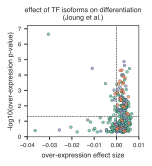

In [62]:
fig = plt.figure(figsize=(2, 2.2))

ax = sns.scatterplot(data=dn_cats_nonan[dn_cats_nonan["dn_cat"].isin(["ref", "rewire", "DN"])], 
                     x="Diffusion difference", y="neglog_diff_pval", 
                     hue="dn_cat", palette=pal, linewidth=0.25, edgecolor="black", alpha=0.8, zorder=10,
                     **{"s": 8})

ax.set_xlabel("over-expression effect size")
ax.set_ylabel("-log10(over-expression p-value)")
ax.set_title("effect of TF isoforms on differentiation\n(Joung et al.)")

ax.set_xlim((-0.04, 0.01))
ax.set_ylim((-0.01, 7.2))
ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=0.5)
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)

ax.get_legend().remove()

fig.savefig("../figures/Joung_Volcano.pdf", dpi="figure", bbox_inches="tight")

In [63]:
tmp = dn_cats_nonan[dn_cats_nonan["dn_cat"]=="DN"]
#tmp = tmp[tmp["neglog_diff_pval"] > 3]
tmp.sort_values(by="neglog_diff_pval", 
                ascending=False)[["tf1p0_id", "dn_cat", "Diffusion difference",
                                 "neglog_diff_pval", "tot_cell_cnt"]].head()

,tf1p0_id,dn_cat,Diffusion difference,neglog_diff_pval,tot_cell_cnt
235,PBX1|2/2|02C05,DN,0.002412,4.319664,1000
245,DLX1|2/2|07E09,DN,0.001693,4.285670,1000
294,ZNF394|2/3|09G08,DN,0.002945,3.915706,1000
397,PKNOX1|3/4|06H03,DN,0.003959,3.798218,251
365,ZNF24|2/2|01A09,DN,0.001518,3.615043,830


## 11. enrichment heatmaps

In [64]:
joung_cells["Name"] = joung_cells["TF"].str.strip().str.split("-", expand=True)[0]
print(len(joung_cells))

# # filter out anything with score < 0.2
joung_cells = joung_cells[joung_cells["prediction.score.max"] > 0.2]
print(len(joung_cells))

28825
23604


In [65]:
joung_cells_grp = joung_cells.groupby(["Name", "TF", "predicted.id"])["batch"].agg("count").reset_index()

In [66]:
tot_cell_cnt = dn_cats_nonan[["Name", "TF", "tot_cell_cnt"]].drop_duplicates()
diff_cell_cnt = joung_cells.groupby(["Name", "TF"])["batch"].agg("count").reset_index()
cell_cnt = tot_cell_cnt.merge(diff_cell_cnt, on=["Name", "TF"], how="left")
cell_cnt.fillna(0, inplace=True)
cell_cnt.columns = ["Name", "TF", "tot_cell_cnt", "diff_cell_cnt"]

orf_enr = cell_cnt.merge(joung_cells_grp, on=["Name", "TF"], how="left")
orf_enr["batch"].fillna(0, inplace=True)

orf_enr.columns = ["Name", "TF", "tot_cell_cnt", "diff_cell_cnt", "predicted.id", "id_cell_cnt"]
orf_enr["perc_cells_of_diff_tf"] = orf_enr["id_cell_cnt"]/orf_enr["diff_cell_cnt"]
orf_enr["perc_cells_of_tot_tf"] = orf_enr["id_cell_cnt"]/orf_enr["tot_cell_cnt"]

In [67]:
orf_enr_dn = orf_enr.merge(dn_cats_nonan[["gene_name", "Name", "tf1p0_id",
                                          "dn_cat"]], on="Name").drop_duplicates(subset=["tf1p0_id",
                                                                                         "predicted.id",
                                                                                         "dn_cat"])

In [68]:
has_alt = list(orf_enr_dn[orf_enr_dn["dn_cat"] != "ref"]["gene_name"].unique())
orf_enr_dn_filt = orf_enr_dn[orf_enr_dn["gene_name"].isin(has_alt)]

has_ref = list(orf_enr_dn_filt[orf_enr_dn_filt["dn_cat"] == "ref"]["gene_name"].unique())
orf_enr_dn_filt = orf_enr_dn_filt[orf_enr_dn_filt["gene_name"].isin(has_ref)]
len(orf_enr_dn_filt)

1048

In [69]:
orf_enr_dn_filt["dn_cat_s"] = pd.Categorical(orf_enr_dn_filt["dn_cat"], ["ref", "rewire", "DN", "NA", "likely"])
orf_enr_dn_filt = orf_enr_dn_filt.sort_values(by=["gene_name", "dn_cat_s"])
orf_enr_dn_filt[orf_enr_dn_filt["gene_name"] == "PBX1"]

,Name,TF,tot_cell_cnt,diff_cell_cnt,predicted.id,id_cell_cnt,perc_cells_of_diff_tf,perc_cells_of_tot_tf,gene_name,tf1p0_id,dn_cat,dn_cat_s
32,TFORF0427,TFORF0427-PBX1,285,7.0,Ciliated epithelial cells,1.0,0.142857,0.003509,PBX1,PBX1|1/2|02A05,ref,ref
33,TFORF0427,TFORF0427-PBX1,285,7.0,Intestinal epithelial cells,1.0,0.142857,0.003509,PBX1,PBX1|1/2|02A05,ref,ref
34,TFORF0427,TFORF0427-PBX1,285,7.0,Metanephric cells,1.0,0.142857,0.003509,PBX1,PBX1|1/2|02A05,ref,ref
35,TFORF0427,TFORF0427-PBX1,285,7.0,STC2_TLX1 positive cells,1.0,0.142857,0.003509,PBX1,PBX1|1/2|02A05,ref,ref
36,TFORF0427,TFORF0427-PBX1,285,7.0,Squamous epithelial cells,3.0,0.428571,0.010526,PBX1,PBX1|1/2|02A05,ref,ref
571,TFORF0429,TFORF0429-PBX1,1000,27.0,Bronchiolar and alveolar epithelial cells,1.0,0.037037,0.001000,PBX1,PBX1|2/2|02C05,DN,DN
572,TFORF0429,TFORF0429-PBX1,1000,27.0,Ciliated epithelial cells,1.0,0.037037,0.001000,PBX1,PBX1|2/2|02C05,DN,DN
573,TFORF0429,TFORF0429-PBX1,1000,27.0,Erythroblasts,5.0,0.185185,0.005000,PBX1,PBX1|2/2|02C05,DN,DN
574,TFORF0429,TFORF0429-PBX1,1000,27.0,Inhibitory neurons,1.0,0.037037,0.001000,PBX1,PBX1|2/2|02C05,DN,DN
575,TFORF0429,TFORF0429-PBX1,1000,27.0,Intestinal epithelial cells,2.0,0.074074,0.002000,PBX1,PBX1|2/2|02C05,DN,DN


In [70]:
cell_cnt["undiff_cell_cnt"] = cell_cnt["tot_cell_cnt"] - cell_cnt["diff_cell_cnt"]
len(cell_cnt)

399

In [71]:
cell_cnt["diff_cell_perc"] = (cell_cnt["diff_cell_cnt"]/cell_cnt["tot_cell_cnt"])*100
cell_cnt["undiff_cell_perc"] = (cell_cnt["undiff_cell_cnt"]/cell_cnt["tot_cell_cnt"])*100
cell_cnt[cell_cnt["TF"].str.contains("GRHL3")]

,Name,TF,tot_cell_cnt,diff_cell_cnt,undiff_cell_cnt,diff_cell_perc,undiff_cell_perc
4,TFORF2165,TFORF2165-GRHL3,111,36.0,75.0,32.432432,67.567568
222,TFORF2166,TFORF2166-GRHL3,47,0.0,47.0,0.000000,100.000000
223,TFORF2167,TFORF2167-GRHL3,500,12.0,488.0,2.400000,97.600000
224,TFORF2168,TFORF2168-GRHL3,152,40.0,112.0,26.315789,73.684211


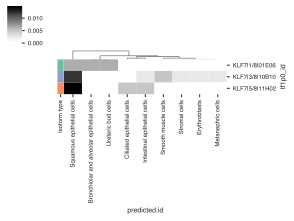

In [72]:
tmp = orf_enr_dn_filt[orf_enr_dn_filt["tf1p0_id"].str.contains("KLF7")].pivot(index="tf1p0_id", 
                                                                              columns="predicted.id", 
                                                                              values="perc_cells_of_tot_tf")
tmp.fillna(0, inplace=True)

idx = pd.DataFrame(tmp.index)
idx = idx.merge(orf_enr_dn_filt[["tf1p0_id", "dn_cat"]], on="tf1p0_id").drop_duplicates().set_index("tf1p0_id")
idx["Isoform type"] = idx.dn_cat.map(pal)

g = sns.clustermap(tmp, cmap="Greys", row_cluster=False, row_colors=idx["Isoform type"],
               figsize=(4, 2.5), yticklabels=True, cbar_pos=(0, 1, 0.05, 0.2))
g.savefig("../figures/Joung_KLF7_hm.pdf", bbox_inches="tight", dpi="figure")

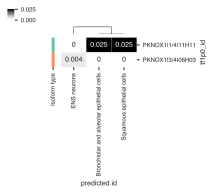

In [73]:
tmp = orf_enr_dn_filt[orf_enr_dn_filt["tf1p0_id"].str.contains("PKNOX1")].pivot(index="tf1p0_id", 
                                                                              columns="predicted.id", 
                                                                              values="perc_cells_of_tot_tf")
tmp.fillna(0, inplace=True)

idx = pd.DataFrame(tmp.index)
idx = idx.merge(orf_enr_dn_filt[["tf1p0_id", "dn_cat"]], on="tf1p0_id").drop_duplicates().set_index("tf1p0_id")
idx["Isoform type"] = idx.dn_cat.map(pal)

g = sns.clustermap(tmp, cmap="Greys", row_cluster=False, row_colors=idx["Isoform type"],
               figsize=(2, 0.75), yticklabels=True, cbar_pos=(0, 1, 0.05, 0.2), annot=True)
g.savefig("../figures/Joung_PKNOX1_hm.pdf", bbox_inches="tight", dpi="figure")

In [74]:
cell_cnt[cell_cnt["TF"].str.contains("PKNOX1")]

,Name,TF,tot_cell_cnt,diff_cell_cnt,undiff_cell_cnt,diff_cell_perc,undiff_cell_perc
211,TFORF3468,TFORF3468-PKNOX1,40,2.0,38.0,5.000000,95.000000
394,TFORF1274,TFORF1274-PKNOX1,251,1.0,250.0,0.398406,99.601594


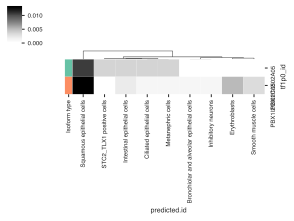

In [75]:
tmp = orf_enr_dn_filt[orf_enr_dn_filt["tf1p0_id"].str.contains("PBX1")].pivot(index="tf1p0_id", 
                                                                              columns="predicted.id", 
                                                                              values="perc_cells_of_tot_tf")
tmp.fillna(0, inplace=True)

idx = pd.DataFrame(tmp.index)
idx = idx.merge(orf_enr_dn_filt[["tf1p0_id", "dn_cat"]], on="tf1p0_id").drop_duplicates().set_index("tf1p0_id")
idx["Isoform type"] = idx.dn_cat.map(pal)

g = sns.clustermap(tmp, cmap="Greys", row_cluster=False, row_colors=idx["Isoform type"],
               figsize=(4, 2.5), yticklabels=True, cbar_pos=(0, 1, 0.05, 0.2))
# g.savefig("../figures/Joung_HOXA1_hm.pdf", bbox_inches="tight", dpi="figure")

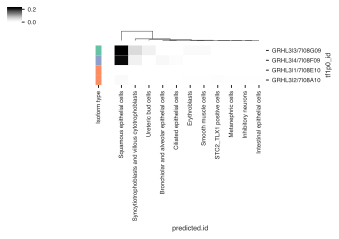

In [76]:
tmp = orf_enr_dn_filt[orf_enr_dn_filt["tf1p0_id"].str.contains("GRHL3")].pivot(index="tf1p0_id", 
                                                                               columns="predicted.id", 
                                                                               values="perc_cells_of_tot_tf")
tmp.drop(np.nan, axis=1, inplace=True)
tmp = tmp.loc[["GRHL3|3/7|08G09", "GRHL3|4/7|08F09", "GRHL3|1/7|08E10", "GRHL3|2/7|08A10"]]
tmp.fillna(0, inplace=True)

idx = pd.DataFrame(tmp.index)
idx = idx.merge(orf_enr_dn_filt[["tf1p0_id", "dn_cat"]], on="tf1p0_id").drop_duplicates().set_index("tf1p0_id")
idx["Isoform type"] = idx.dn_cat.map(pal)

g = sns.clustermap(tmp, cmap="Greys", row_cluster=False, row_colors=idx["Isoform type"],
                   figsize=(4, 1), yticklabels=True, cbar_pos=(0, 1, 0.05, 0.2))

g.savefig("../figures/Joung_GRHL3_hm.pdf", bbox_inches="tight", dpi="figure")

## 12. write files

In [77]:
joung_orf.to_csv("../data/processed/Joung_ORF_annotated.tsv", sep="\t", index=False)

In [78]:
dn_cats.to_csv("../data/processed/DN_cats_Joung.tsv", sep="\t", index=False)

In [81]:
joung_orf[joung_orf["RefSeq Gene Name"] == "GRHL3"]

,Source,Name,RefSeq Gene Name,RefSeq and Gencode ID,Isoform ID,Insert,ORF sequence,Barcode Sequence,Epitope Tag,Unsorted M1,...,Sorted M4,Sorted M5,Sorted M6,Sorted M7,seq_aa_joung,index,match_type,joung_id,enst,seq_aa_tf1p0
2164,Genewiz,TFORF2165,GRHL3,"NM_198173,ENST00000361548",GRHL3-1,ACCGCCACCATGTCGAATGAACTTGATTTCAGGTCTGTGCGGCTGC...,ATGTCGAATGAACTTGATTTCAGGTCTGTGCGGCTGCTAAAGAACG...,GGTGGTAACGCTGTAGGAATACTC,None,0.679035,...,1.409354,1.433353,0.942051,0.883889,MSNELDFRSVRLLKNDPVNLQKFSYTSEDEAWKTYLENPLTAATKA...,GRHL3|3/7|08G09,seq_aa,TFORF2165,[ENST00000361548],MSNELDFRSVRLLKNDPVNLQKFSYTSEDEAWKTYLENPLTAATKA...
2165,Genewiz,TFORF2166,GRHL3,"NM_198174,ENST00000350501",GRHL3-2,ACCGCCACCATGTCGAATGAACTTGATTTCAGGTCTGTGCGGCTGC...,ATGTCGAATGAACTTGATTTCAGGTCTGTGCGGCTGCTAAAGAACG...,TCCTCGCAGAATCACCAATTATCG,None,0.521070,...,0.877675,1.001799,0.524561,0.785591,MSNELDFRSVRLLKNDPVNLQKFSYTSEDEAWKTYLENPLTAATKA...,GRHL3|1/7|08E10,seq_aa,TFORF2166,[ENST00000350501],MSNELDFRSVRLLKNDPVNLQKFSYTSEDEAWKTYLENPLTAATKA...
2166,Genewiz,TFORF2167,GRHL3,"NM_021180,ENST00000236255",GRHL3-3,ACCGCCACCATGTGGATGAATTCCATTCTTCCTATTTTTCTTTTCA...,ATGTGGATGAATTCCATTCTTCCTATTTTTCTTTTCAGGTCTGTGC...,TTGCGGACTTTCCTGAATCGGAGA,None,0.692893,...,0.501974,0.652385,1.596049,0.619516,MWMNSILPIFLFRSVRLLKNDPVNLQKFSYTSEDEAWKTYLENPLT...,GRHL3|2/7|08A10,seq_aa,TFORF2167,[ENST00000236255],MWMNSILPIFLFRSVRLLKNDPVNLQKFSYTSEDEAWKTYLENPLT...
2167,Genewiz,TFORF2168,GRHL3,"NM_001195010,XM_011541869,ENST00000356046",GRHL3-4,ACCGCCACCATGATGAGAGTCAATGGAGATGATGACAGTGTTGCGG...,ATGATGAGAGTCAATGGAGATGATGACAGTGTTGCGGCCTTGAGCT...,AGCACACATGACATGTGGCGGGAC,None,0.705489,...,1.805838,1.151655,1.429631,1.062048,MMRVNGDDDSVAALSFLYDYYMGPKEKRILSSSTGGRNDQGKRYYH...,GRHL3|4/7|08F09,seq_aa,TFORF2168,[ENST00000356046],MMRVNGDDDSVAALSFLYDYYMGPKEKRILSSSTGGRNDQGKRYYH...


In [118]:
joung_orf[joung_orf["RefSeq Gene Name"] == "TBX5"]

,Source,Name,RefSeq Gene Name,RefSeq and Gencode ID,Isoform ID,Insert,ORF sequence,Barcode Sequence,Epitope Tag,Unsorted M1,...,Sorted M4,Sorted M5,Sorted M6,Sorted M7,seq_aa_joung,index,match_type,joung_id,enst,seq_aa_tf1p0
1981,Genewiz,TFORF1982,TBX5,"NM_080717,ENST00000349716",TBX5-1,ACCGCCACCATGGAGGGAATCAAAGTGTTTCTCCATGAAAGAGAAC...,ATGGAGGGAATCAAAGTGTTTCTCCATGAAAGAGAACTGTGGCTAA...,ACGCTCCAGGGACTGATTGGACAC,None,0.965697,...,0.757321,0.825919,0.519149,0.623042,MEGIKVFLHERELWLKFHEVGTEMIITKAGRRMFPSYKVKVTGLNP...,TBX5|2/3|08C02,seq_aa,TFORF1982,[ENST00000349716],MEGIKVFLHERELWLKFHEVGTEMIITKAGRRMFPSYKVKVTGLNP...
1982,Genewiz,TFORF1983,TBX5,"NM_181486,NM_000192,ENST00000310346,ENST000004...",TBX5-2,ACCGCCACCATGGCCGACGCAGACGAGGGCTTTGGCCTGGCGCACA...,ATGGCCGACGCAGACGAGGGCTTTGGCCTGGCGCACACGCCTCTGG...,ACCTCACACAGGGTGAAGCATGGA,None,0.507876,...,0.893095,0.453838,0.749560,1.087550,MADADEGFGLAHTPLEPDAKDLPCDSKPESALGAPSKSPSSPQAAF...,TBX5|1/3|08E01,seq_aa,TFORF1983,"[ENST00000310346, ENST00000405440]",MADADEGFGLAHTPLEPDAKDLPCDSKPESALGAPSKSPSSPQAAF...


In [122]:
tfs["TBX5"]["TBX5|1/3|08E01"].aa_seq

'MADADEGFGLAHTPLEPDAKDLPCDSKPESALGAPSKSPSSPQAAFTQQGMEGIKVFLHERELWLKFHEVGTEMIITKAGRRMFPSYKVKVTGLNPKTKYILLMDIVPADDHRYKFADNKWSVTGKAEPAMPGRLYVHPDSPATGAHWMRQLVSFQKLKLTNNHLDPFGHIILNSMHKYQPRLHIVKADENNGFGSKNTAFCTHVFPETAFIAVTSYQNHKITQLKIENNPFAKGFRGSDDMELHRMSRMQSKEYPVVPRSTVRQKVASNHSPFSSESRALSTSSNLGSQYQCENGVSGPSQDLLPPPNPYPLPQEHSQIYHCTKRKEEECSTTDHPYKKPYMETSPSEEDSFYRSSYPQQQGLGASYRTESAQRQACMYASSAPPSEPVPSLEDISCNTWPSMPSYSSCTVTTVQPMDRLPYQHFSAHFTSGPLVPRLAGMANHGSPQLGEGMFQHQTSVAHQPVVRQCGPQTGLQSPGTLQPPEFLYSHGVPRTLSPHQYHSVHGVGMVPEWSDNS'

In [123]:
len(tfs["TBX5"]["TBX5|1/3|08E01"].aa_seq)

518

In [125]:
tfs["TBX5"]["TBX5|2/3|08C02"].aa_seq

'MEGIKVFLHERELWLKFHEVGTEMIITKAGRRMFPSYKVKVTGLNPKTKYILLMDIVPADDHRYKFADNKWSVTGKAEPAMPGRLYVHPDSPATGAHWMRQLVSFQKLKLTNNHLDPFGHIILNSMHKYQPRLHIVKADENNGFGSKNTAFCTHVFPETAFIAVTSYQNHKITQLKIENNPFAKGFRGSDDMELHRMSRMQSKEYPVVPRSTVRQKVASNHSPFSSESRALSTSSNLGSQYQCENGVSGPSQDLLPPPNPYPLPQEHSQIYHCTKRKEEECSTTDHPYKKPYMETSPSEEDSFYRSSYPQQQGLGASYRTESAQRQACMYASSAPPSEPVPSLEDISCNTWPSMPSYSSCTVTTVQPMDRLPYQHFSAHFTSGPLVPRLAGMANHGSPQLGEGMFQHQTSVAHQPVVRQCGPQTGLQSPGTLQPPEFLYSHGVPRTLSPHQYHSVHGVGMVPEWSDNS'

In [126]:
len(tfs["TBX5"]["TBX5|2/3|08C02"].aa_seq)

468

In [128]:
tfs["TBX5"].isoforms

[Clone acc: TBX5|1/3|08E01
 Isoform: TBX5-201|TBX5-203 / ENSP00000309913|ENSP00000384152 / ENST00000310346|ENST00000405440
 length: 518 aa,
 Clone acc: TBX5|2/3|08C02
 Isoform: TBX5-202 / ENSP00000337723 / ENST00000349716
 length: 468 aa,
 Clone acc: TBX5|3/3|08H01
 Isoform: TBX5-204 / ENSP00000433292 / ENST00000526441
 length: 349 aa]